In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib

In [53]:
df = pd.read_csv("BTC_1_hour_4_years.csv", parse_dates=["open_time"], index_col='open_time')
df.head()

,open,high,low,close,volume
open_time,,,,,
2020-11-27 00:00:00,17155.37,17418.93,17024.20,17400.00,15427.474
2020-11-27 01:00:00,17401.51,17465.00,17271.30,17309.94,16632.689
2020-11-27 02:00:00,17309.93,17328.09,17072.80,17102.38,16168.837
2020-11-27 03:00:00,17102.10,17277.86,17029.32,17084.05,13670.593
2020-11-27 04:00:00,17084.05,17194.00,17061.00,17079.56,10866.299


In [54]:
# df = pd.read_csv("../BTC_1_year_data.csv").set_index("close_time")
# df

#### Feature Engineering


In [55]:
df["close_log_return"] = np.log(df["close"] / df["close"].shift())

    Create lagged features


In [56]:
df = df.copy()

In [57]:
def generate_ma_features(df, close_col="close", windows=[5, 10], shift_pct=True):
    """
    Generate moving average and pct-change-to-close features for a list of window sizes.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least a 'close' column.
    close_col : str
        Column name for the close price.
    windows : list
        List of integers for rolling windows.
    shift_pct : bool
        Whether to shift pct-change features by 1 step to avoid leakage.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with new features added.
    """
    df = df.copy()

    for w in windows:
        ma_col = f"{w}ma"
        pct_col = f"pct_change_{w}ma_close"

        # Moving average
        df[ma_col] = df[close_col].rolling(w).mean()

        # Percentage difference from MA
        df[pct_col] = (df[close_col] - df[ma_col]) / df[ma_col] * 100

        # Shift to avoid leakage (optional)
        if shift_pct:
            df[pct_col] = df[pct_col].shift()

    return df


windows = [10, 50, 200]

df = generate_ma_features(df, windows=windows)

In [58]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [59]:
df = df.dropna(how="any")
# df= df.drop(columns=["open", "high", "low", "close", "volume"])

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down


In [60]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x: 1 if x > 0 else 0)
# df = df.drop(columns="close_log_return")

In [61]:
df

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
open_time,,,,,,,,,,,,,,,,
2020-12-05 08:00:00,18919.12,19203.46,18919.12,19161.02,14425.012,0.012704,18861.459,0.565446,19153.3664,-1.203730,18500.78670,2.309911,-0.002661,0.000278,0.004934,1
2020-12-05 09:00:00,19161.10,19180.00,19073.40,19125.01,6662.840,-0.001881,18907.540,1.588218,19151.5956,0.039960,18509.86205,3.568677,0.012704,-0.002661,0.000278,0
2020-12-05 10:00:00,19125.01,19150.00,19050.00,19129.00,5521.861,0.000209,18942.823,1.150176,19146.0710,-0.138817,18519.99515,3.323352,-0.001881,0.012704,-0.002661,1
2020-12-05 11:00:00,19128.99,19137.40,18972.29,19025.97,10652.365,-0.005401,18979.586,0.982837,19139.0808,-0.089162,18529.70475,3.288364,0.000209,-0.001881,0.012704,0
2020-12-05 12:00:00,19025.15,19088.57,18972.31,19070.72,7832.301,0.002349,19006.417,0.244389,19132.9872,-0.590994,18539.66055,2.678215,-0.005401,0.000209,-0.001881,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-10 19:00:00,105435.90,106000.00,105354.00,105767.20,2971.178,0.003138,105666.640,-0.278369,103978.1040,1.476529,103973.82350,1.379880,-0.004455,0.006797,0.001525,1
2025-11-10 20:00:00,105767.10,106249.60,105750.30,105956.70,3483.547,0.001790,105667.700,0.095167,104055.5500,1.720647,103950.15300,1.724835,0.003138,-0.004455,0.006797,1
2025-11-10 21:00:00,105956.70,105973.90,105202.70,105583.50,3305.325,-0.003528,105612.390,0.273499,104128.5340,1.827053,103925.50550,1.930297,0.001790,0.003138,-0.004455,0


    Check class imbalance


In [62]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
1    21918
0    21322
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order


In [63]:
def time_split(x, train_size=0.75):
    i = int(len(x) * train_size)
    return x[:i].copy(), x[i:].copy()


df_train, df_test = time_split(df, train_size=0.7)

In [64]:
df_train

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
open_time,,,,,,,,,,,,,,,,
2020-12-05 08:00:00,18919.12,19203.46,18919.12,19161.02,14425.012,0.012704,18861.459,0.565446,19153.3664,-1.203730,18500.78670,2.309911,-0.002661,0.000278,0.004934,1
2020-12-05 09:00:00,19161.10,19180.00,19073.40,19125.01,6662.840,-0.001881,18907.540,1.588218,19151.5956,0.039960,18509.86205,3.568677,0.012704,-0.002661,0.000278,0
2020-12-05 10:00:00,19125.01,19150.00,19050.00,19129.00,5521.861,0.000209,18942.823,1.150176,19146.0710,-0.138817,18519.99515,3.323352,-0.001881,0.012704,-0.002661,1
2020-12-05 11:00:00,19128.99,19137.40,18972.29,19025.97,10652.365,-0.005401,18979.586,0.982837,19139.0808,-0.089162,18529.70475,3.288364,0.000209,-0.001881,0.012704,0
2020-12-05 12:00:00,19025.15,19088.57,18972.31,19070.72,7832.301,0.002349,19006.417,0.244389,19132.9872,-0.590994,18539.66055,2.678215,-0.005401,0.000209,-0.001881,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-19 06:00:00,67069.50,67125.00,66895.00,66994.10,2895.882,-0.001125,66991.270,0.125759,66778.1320,0.483613,63712.07850,5.320699,-0.000753,-0.000194,-0.000618,0
2024-05-19 07:00:00,66994.20,67313.80,66947.50,67295.00,6551.235,0.004481,67033.790,0.004224,66810.5340,0.323411,63744.66300,5.151333,-0.001125,-0.000753,-0.000194,1
2024-05-19 08:00:00,67295.10,67320.80,67063.00,67124.30,3595.846,-0.002540,67057.220,0.389669,66834.6600,0.725134,63776.51650,5.569622,0.004481,-0.001125,-0.000753,0


In [65]:
df_test

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
open_time,,,,,,,,,,,,,,,,
2024-05-19 11:00:00,67247.0,67368.0,66921.9,67303.3,13112.332,0.000838,67160.75,0.189333,66892.802,0.558792,63872.9540,5.336676,0.001488,0.000337,-0.002540,1
2024-05-19 12:00:00,67303.4,67303.4,66750.0,66799.0,10415.097,-0.007521,67123.20,0.212252,66899.484,0.613665,63903.2510,5.370577,0.000838,0.001488,0.000337,0
2024-05-19 13:00:00,66798.9,67149.9,66619.4,67010.5,10038.562,0.003161,67110.95,-0.482992,66916.040,-0.150201,63933.8005,4.531458,-0.007521,0.000838,0.001488,1
2024-05-19 14:00:00,67010.5,67119.8,66812.2,66895.9,4578.498,-0.001712,67088.54,-0.149678,66926.956,0.141162,63963.6530,4.812321,0.003161,-0.007521,0.000838,0
2024-05-19 15:00:00,66896.0,66968.1,66700.2,66863.0,4603.025,-0.000492,67067.89,-0.287143,66945.842,-0.046403,63993.0235,4.584239,-0.001712,0.003161,-0.007521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-10 19:00:00,105435.9,106000.0,105354.0,105767.2,2971.178,0.003138,105666.64,-0.278369,103978.104,1.476529,103973.8235,1.379880,-0.004455,0.006797,0.001525,1
2025-11-10 20:00:00,105767.1,106249.6,105750.3,105956.7,3483.547,0.001790,105667.70,0.095167,104055.550,1.720647,103950.1530,1.724835,0.003138,-0.004455,0.006797,1
2025-11-10 21:00:00,105956.7,105973.9,105202.7,105583.5,3305.325,-0.003528,105612.39,0.273499,104128.534,1.827053,103925.5055,1.930297,0.001790,0.003138,-0.004455,0


In [66]:
print(df_train["close_log_return_dir"].value_counts())
print(df_test["close_log_return_dir"].value_counts())

close_log_return_dir
1    15372
0    14895
Name: count, dtype: int64
close_log_return_dir
1    6546
0    6427
Name: count, dtype: int64


### Scikit-learn Logistic Regression


### Research


In [67]:
btcusdt_train = df_train.copy()
btcusdt_test = df_test.copy()

In [68]:
btcusdt_test

,open,high,low,close,volume,close_log_return,10ma,pct_change_10ma_close,50ma,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,close_log_return_dir
open_time,,,,,,,,,,,,,,,,
2024-05-19 11:00:00,67247.0,67368.0,66921.9,67303.3,13112.332,0.000838,67160.75,0.189333,66892.802,0.558792,63872.9540,5.336676,0.001488,0.000337,-0.002540,1
2024-05-19 12:00:00,67303.4,67303.4,66750.0,66799.0,10415.097,-0.007521,67123.20,0.212252,66899.484,0.613665,63903.2510,5.370577,0.000838,0.001488,0.000337,0
2024-05-19 13:00:00,66798.9,67149.9,66619.4,67010.5,10038.562,0.003161,67110.95,-0.482992,66916.040,-0.150201,63933.8005,4.531458,-0.007521,0.000838,0.001488,1
2024-05-19 14:00:00,67010.5,67119.8,66812.2,66895.9,4578.498,-0.001712,67088.54,-0.149678,66926.956,0.141162,63963.6530,4.812321,0.003161,-0.007521,0.000838,0
2024-05-19 15:00:00,66896.0,66968.1,66700.2,66863.0,4603.025,-0.000492,67067.89,-0.287143,66945.842,-0.046403,63993.0235,4.584239,-0.001712,0.003161,-0.007521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-10 19:00:00,105435.9,106000.0,105354.0,105767.2,2971.178,0.003138,105666.64,-0.278369,103978.104,1.476529,103973.8235,1.379880,-0.004455,0.006797,0.001525,1
2025-11-10 20:00:00,105767.1,106249.6,105750.3,105956.7,3483.547,0.001790,105667.70,0.095167,104055.550,1.720647,103950.1530,1.724835,0.003138,-0.004455,0.006797,1
2025-11-10 21:00:00,105956.7,105973.9,105202.7,105583.5,3305.325,-0.003528,105612.39,0.273499,104128.534,1.827053,103925.5055,1.930297,0.001790,0.003138,-0.004455,0


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------
# 0. REPRODUCIBILITY SETTINGS
# -------------------------------------------------------
SEED = 99
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# -------------------------------------------------------
# 1. STANDARDIZE FEATURES AND CREATE TENSORS
# -------------------------------------------------------

features = [
    "close_log_return_lag_1",
    "close_log_return_lag_2",
    "close_log_return_lag_3"
]
target = "close_log_return_dir"

# Fit scaler on training set only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(btcusdt_train[features].values)
X_test_scaled = scaler.transform(btcusdt_test[features].values)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train = torch.tensor(btcusdt_train[target].values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(btcusdt_test[target].values, dtype=torch.float32).unsqueeze(1)

# -------------------------------------------------------
# 2. DEFINE MODEL (Logistic Regression)
# -------------------------------------------------------

no_features = len(features)


class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)


model = LogisticRegression(no_features)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# -------------------------------------------------------
# 3. TRAINING LOOP (FULL-BATCH GRADIENT DESCENT)
# -------------------------------------------------------
for epoch in range(20000):
    optimizer.zero_grad()
    y_pred_logits = model(X_train)
    loss = criterion(y_pred_logits, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())

# -------------------------------------------------------
# 4. CHECK TRAINED PARAMETERS
# -------------------------------------------------------
print("\nFinal weight:", model.linear.weight.data)
print("Final bias:", model.linear.bias.data)

# -------------------------------------------------------
# 5. EVALUATION ON TEST SET
# -------------------------------------------------------
with torch.no_grad():
    y_pred_logits = model(X_test)
    y_pred_proba = torch.sigmoid(y_pred_logits)
    y_pred_binary = (y_pred_proba >= 0.5).float()

y_test_np = y_test.squeeze().numpy()
y_pred_binary_np = y_pred_binary.squeeze().numpy()
y_pred_proba_np = y_pred_proba.squeeze().numpy()

# Metrics
accuracy = np.mean(y_pred_binary_np == y_test_np)
buy_signals = np.sum(y_pred_binary_np == 1)

print("\n--- Model Evaluation ---")
print(f"Total Test Samples (T): {len(X_test)}")
print(f"Number of Buy Signals (Predicted UP): {int(buy_signals)}")
print(f"Directional Accuracy (DA): {accuracy:.4f}")

# Optional: confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_np, y_pred_binary_np)
print("\nConfusion Matrix:\n", cm)

Epoch: 0 Loss: 0.8069549202919006
Epoch: 500 Loss: 0.7887377142906189
Epoch: 1000 Loss: 0.7727800607681274
Epoch: 1500 Loss: 0.7589219212532043
Epoch: 2000 Loss: 0.7469947934150696
Epoch: 2500 Loss: 0.7368239164352417
Epoch: 3000 Loss: 0.728230893611908
Epoch: 3500 Loss: 0.7210378646850586
Epoch: 4000 Loss: 0.7150707840919495
Epoch: 4500 Loss: 0.7101631164550781
Epoch: 5000 Loss: 0.7061594128608704
Epoch: 5500 Loss: 0.702917218208313
Epoch: 6000 Loss: 0.7003093957901001
Epoch: 6500 Loss: 0.698223888874054
Epoch: 7000 Loss: 0.6965646147727966
Epoch: 7500 Loss: 0.6952500939369202
Epoch: 8000 Loss: 0.6942122578620911
Epoch: 8500 Loss: 0.6933951377868652
Epoch: 9000 Loss: 0.692753255367279
Epoch: 9500 Loss: 0.6922497749328613
Epoch: 10000 Loss: 0.6918554306030273
Epoch: 10500 Loss: 0.6915468573570251
Epoch: 11000 Loss: 0.6913054585456848
Epoch: 11500 Loss: 0.6911166310310364
Epoch: 12000 Loss: 0.6909691691398621
Epoch: 12500 Loss: 0.6908540725708008
Epoch: 13000 Loss: 0.6907640099525452
Ep

In [70]:
confusion_matrix(y_test_np, y_pred_binary_np)

array([[1980, 4447],
       [1764, 4782]])

<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class


In [71]:
TN = cm[0][0]  # True Down  - When it should be down and model predicted down
FN = cm[1][0]  # False down - When it should be up but the model predicted down
FP = cm[0][1]  # False up   - When it should be down but the model predicted up
TP = cm[1][1]  # True UP    - When it should be up and the model predicted up

#### Evaluate win rate


    Accuracy Measure


In [72]:
(TP + TN) / (TP + TN + FP + FN)

np.float64(0.521236414090804)

#### Evaluate the up Predictibility


In [73]:
TP / (TP + FP)

np.float64(0.5181493119514574)

#### Evaluate the up Predictibility


<p style="color: yellow; font-size: 20px">Recall</p>


In [74]:
TP / (
    TP + FN
)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.7305224564619615)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [75]:
TP / (TP + FP)  # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.5181493119514574)

#### Evaluate down predictability


<p style="color: yellow; font-size: 20px">Recall</p>


In [76]:
TN / (
    TN + FP
)  # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.30807530729733934)

In [77]:
TN / (TN + FN)  # From as many times I predicted false, how many were actually false.

np.float64(0.5288461538461539)

###### **PRECISION**

###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**

###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

|                     | Precision                | Recall                        |
| ------------------- | ------------------------ | ----------------------------- |
| **Perspective**     | YOUR predictions         | REALITY's events              |
| **Denominator**     | What YOU predicted       | What ACTUALLY happened        |
| **Question**        | "Am I accurate?"         | "Am I thorough?"              |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**

- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**

- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**

- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio


In [78]:
short_ratio = (FN + TN) / (FN + TN + FP + FP)
short_ratio

np.float64(0.2962494065516696)

#### Directional Balance: Long Ratio


In [79]:
long_ratio = (FP + TP) / (FN + TN + FP + FP)
long_ratio

np.float64(0.7302579522076278)

#### Directional Imbalance


In [80]:
short_ratio / long_ratio

np.float64(0.4056777549030231)

#### Evaluate Reciever Owner Characteristic (ROC curve)


In [81]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [82]:
auc = roc_auc_score(y_test, y_pred_binary_np)
auc

0.5192988818796505

    If auc is less than 0.5, it is below than random guessing
    If auc is 0.5, it is random
    If auc is greater than 0.5, it has a predictive power and a statistical edge
    If auc is 1.0 - Perfect discriminate ability


In [83]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_binary_np)

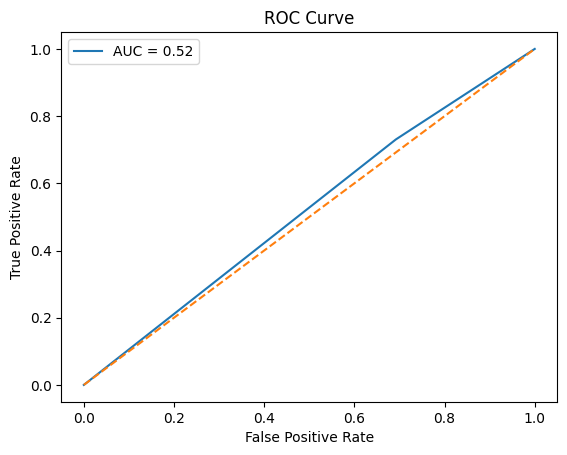

In [84]:
plt.figure()
plt.plot(fpr, tpr, label={f"AUC = {auc:.2f}"})
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#### Evaluating model's profitability (Out-of-sample)


In [85]:
df_test["y_pred_binary"] = y_pred_binary_np
df_test["y_pred_prob"] = y_pred_proba_np

In [86]:
df_test[["close_log_return", "y_pred_binary", "y_pred_prob"]]

,close_log_return,y_pred_binary,y_pred_prob
open_time,,,
2024-05-19 11:00:00,0.000838,1.0,0.506782
2024-05-19 12:00:00,-0.007521,1.0,0.501403
2024-05-19 13:00:00,0.003161,1.0,0.535556
2024-05-19 14:00:00,-0.001712,1.0,0.513869
2024-05-19 15:00:00,-0.000492,1.0,0.521701
...,...,...,...
2025-11-10 19:00:00,0.003138,1.0,0.507656
2025-11-10 20:00:00,0.001790,0.0,0.495514
2025-11-10 21:00:00,-0.003528,1.0,0.501804


#### Add Directional signal


In [87]:
df_test["dir_signal"] = np.where(
    df_test["y_pred_binary"] == 1, 1, -1
)  # We have just replaced the zeroes with -1
df_test[["close_log_return", "y_pred_binary", "y_pred_prob", "dir_signal"]]

,close_log_return,y_pred_binary,y_pred_prob,dir_signal
open_time,,,,
2024-05-19 11:00:00,0.000838,1.0,0.506782,1
2024-05-19 12:00:00,-0.007521,1.0,0.501403,1
2024-05-19 13:00:00,0.003161,1.0,0.535556,1
2024-05-19 14:00:00,-0.001712,1.0,0.513869,1
2024-05-19 15:00:00,-0.000492,1.0,0.521701,1
...,...,...,...,...
2025-11-10 19:00:00,0.003138,1.0,0.507656,1
2025-11-10 20:00:00,0.001790,0.0,0.495514,-1
2025-11-10 21:00:00,-0.003528,1.0,0.501804,1


#### Add trade log return


In [88]:
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test[
    [
        "close_log_return",
        "y_pred_binary",
        "y_pred_prob",
        "dir_signal",
        "trade_log_return",
    ]
]

,close_log_return,y_pred_binary,y_pred_prob,dir_signal,trade_log_return
open_time,,,,,
2024-05-19 11:00:00,0.000838,1.0,0.506782,1,0.000838
2024-05-19 12:00:00,-0.007521,1.0,0.501403,1,-0.007521
2024-05-19 13:00:00,0.003161,1.0,0.535556,1,0.003161
2024-05-19 14:00:00,-0.001712,1.0,0.513869,1,-0.001712
2024-05-19 15:00:00,-0.000492,1.0,0.521701,1,-0.000492
...,...,...,...,...,...
2025-11-10 19:00:00,0.003138,1.0,0.507656,1,0.003138
2025-11-10 20:00:00,0.001790,0.0,0.495514,-1,-0.001790
2025-11-10 21:00:00,-0.003528,1.0,0.501804,1,-0.003528


#### Compound growth returns (Log returns are time additive)


In [89]:
df_test["cum_trade_log_return"] = df_test["trade_log_return"].cumsum()

In [90]:
df_test["cum_trade_log_return"] = df_test["trade_log_return"].cumsum()

<Axes: xlabel='open_time'>

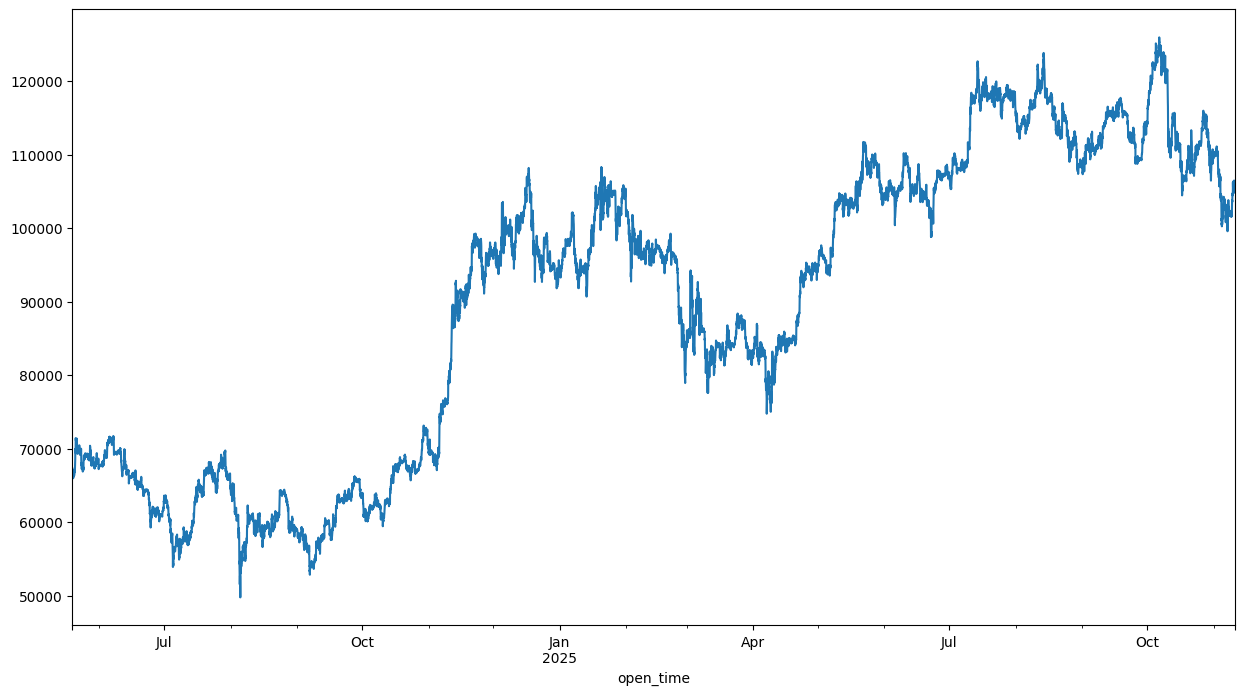

In [91]:
df_test["close"].plot(figsize=(15, 8))

#### Display equity curve


In [92]:
intial_capital = 100

<Axes: xlabel='open_time'>

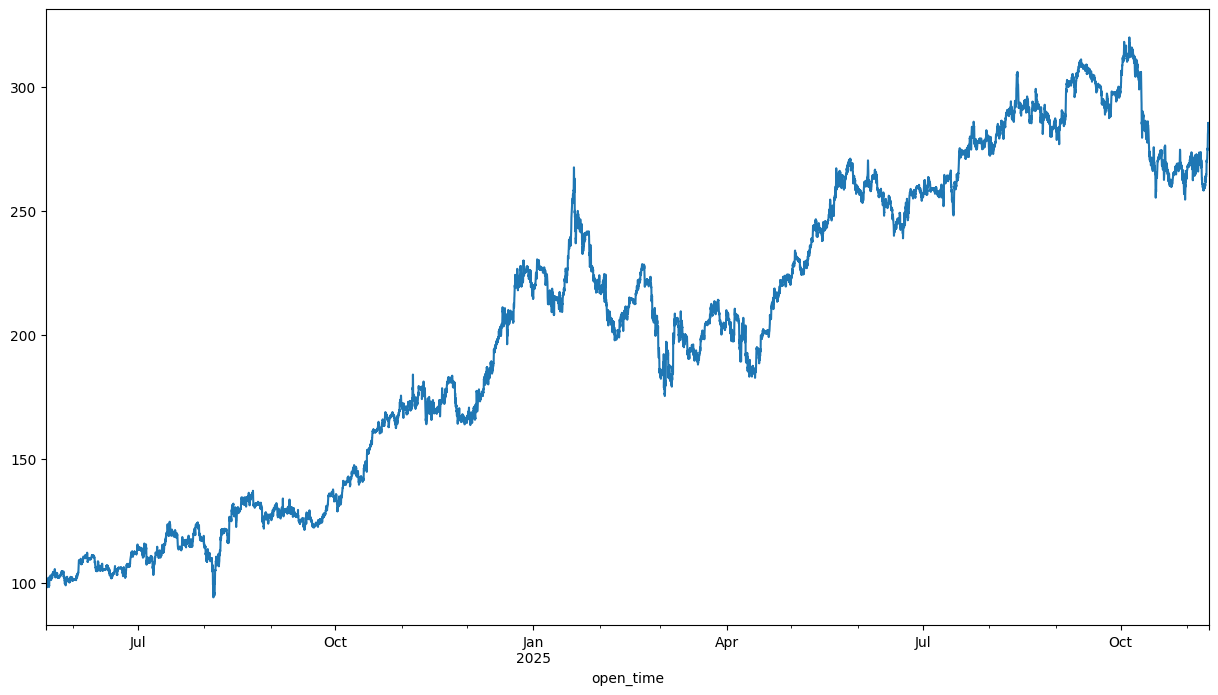

In [93]:
df_test["trade_gross_pnl"] = np.exp(df_test["cum_trade_log_return"]) * intial_capital
df_test["trade_gross_pnl"].plot(figsize=(15, 8))

#### Sharpe Ratio


In [94]:
bars_per_day = 96  # 24h × 4 = 96 bars
days_per_year = 365
t = bars_per_day * days_per_year

sharpe = (
    df_test["trade_log_return"].mean() / df_test["trade_log_return"].std()
) * np.sqrt(t)

print("Sharpe:", sharpe)

Sharpe: 3.0315176893167823


#### Evaluate total compound return

In [95]:
total_compound_return = np.exp(df_test["trade_log_return"].sum())
total_compound_return

np.float64(2.8511689735499544)

#### Evaluate gross pnl

In [96]:
total_compound_return * intial_capital

np.float64(285.11689735499544)

#### Gerko Statistics

In [97]:
# Create a benchmark startegy

In [98]:
rng = np.random.default_rng(SEED)
random_binary = rng.integers(
    low=0,
    high=2, #Generates integers upto but not including 2(i.e. 0 or 1)
    size=len(df_test)
)

# Convert 0/1 to -1/1
df_test["random_dir_signal"] = random_binary * 2 -1
df_test["random_dir_signal"]

open_time
2024-05-19 11:00:00    1
2024-05-19 12:00:00    1
2024-05-19 13:00:00    1
2024-05-19 14:00:00    1
2024-05-19 15:00:00   -1
                      ..
2025-11-10 19:00:00   -1
2025-11-10 20:00:00   -1
2025-11-10 21:00:00    1
2025-11-10 22:00:00   -1
2025-11-10 23:00:00   -1
Name: random_dir_signal, Length: 12973, dtype: int64

In [99]:
df_test["random_trade_log_return"] = df_test["random_dir_signal"] * df_test["close_log_return"]
df_test[
    [
        "close_log_return",
        "random_dir_signal",
        "random_trade_log_return",
    ]
]

,close_log_return,random_dir_signal,random_trade_log_return
open_time,,,
2024-05-19 11:00:00,0.000838,1,0.000838
2024-05-19 12:00:00,-0.007521,1,-0.007521
2024-05-19 13:00:00,0.003161,1,0.003161
2024-05-19 14:00:00,-0.001712,1,-0.001712
2024-05-19 15:00:00,-0.000492,-1,0.000492
...,...,...,...
2025-11-10 19:00:00,0.003138,-1,-0.003138
2025-11-10 20:00:00,0.001790,-1,-0.001790
2025-11-10 21:00:00,-0.003528,1,-0.003528


<Axes: xlabel='open_time'>

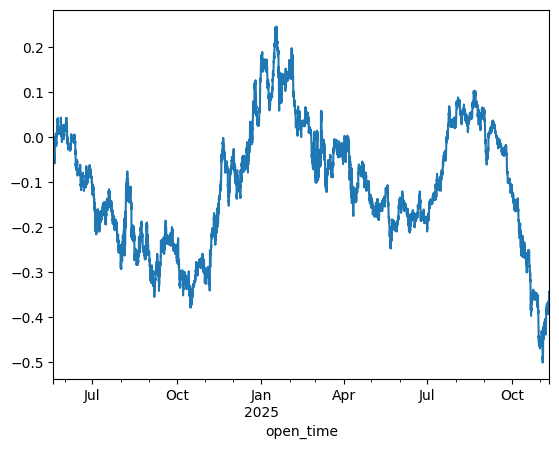

In [100]:
df_test["cum_random_trade_log_return"] = df_test["random_trade_log_return"].cumsum()
df_test["cum_random_trade_log_return"].plot()

<Axes: xlabel='open_time'>

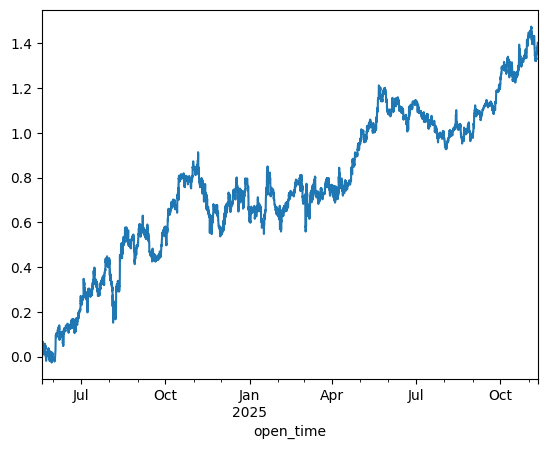

In [101]:
excess_predictability = df_test["cum_trade_log_return"] - df_test["cum_random_trade_log_return"]
excess_predictability.plot()

In [102]:
df_test["trade_log_return"].sum() - df_test["random_trade_log_return"].sum()


np.float64(1.4025411632323148)

#### Decomposition (Anatolyev)